# Deep Metal
## Putting heavy metal into data science

### Part III: Sentiment analysis (ENGLISH) - Genre classification

The notebook contains:

- Word based sentiment analysis
- Sentiment analysis with [VADER](https://www.nltk.org/_modules/nltk/sentiment/vader.html)
- Bands clustering based on sentiment and "metalness"
- Bands emotional arcs
- Emotional arcs applied on literature
- LDA topics extraction

In [1]:
%load_ext autoreload
%autoreload 2
import math
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pycountry
import re
import requests
import scipy
import string
import warnings

from IPython.display import display, HTML, Image, Markdown, Math
from common.graphs import plot_pie_graph, plot_vertical_bars, plot_horizontal_bars, plot_scatter, plot_connected_scatter, plot_3d_scatter, plot_wordcloud, printmd
from mpl_toolkits.mplot3d import Axes3D
from nltk import tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pandarallel import pandarallel
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm

In [2]:
pandarallel.initialize(progress_bar=True)
pd.options.mode.chained_assignment = None
tqdm.pandas()

NO_POPULAR_BANDS = 1000

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## Datasets

- Load the english songs dataset completed with readability, swear word and metalness indexes calculated on the previous notebook (**contains only the first 1000 most popular bands of the original dataset**);
- Load the frequence word list with metalness index;
- Load a ranked word list with happiness index (labMT) (http://hedonometer.org/api/v1/words/?format=json);
- Dump of 100 most common words in metal dataset from previous notebook;

In [3]:
dataset_eng_full_df = pd.read_csv(
    '../datasets/metal_dataset_1000_words_readability_metalness.csv', 
    encoding='utf-8', 
    sep='|'
)
words_metalness_df = pd.read_csv('../datasets/words_metalness.csv', encoding='utf-8', sep='|')
labMT_words_df = pd.read_csv('../datasets/labMT_words.csv', encoding='utf-8', sep='|')
freq_100_most_common_words_df = pd.read_csv('../datasets/freq_100_most_common_words.csv', encoding='utf-8', sep='|')

In [4]:
printmd("**LabMT Hedonometer ranked words**")
labMT_words_df

**LabMT Hedonometer ranked words**

,googleBooksRank,happs,lyricsRank,newYorkTimesRank,rank,stdDev,text,twitterRank,word
0,-1,8.50,1728,-1,1,0.9313,laughter,3600,laughter
1,2458,8.44,1230,-1,2,0.9723,happiness,1853,happiness
2,317,8.42,23,328,3,1.1082,love,25,love
3,1372,8.30,375,1313,4,0.9949,happy,65,happy
4,3542,8.26,2332,-1,5,1.1572,laughed,3334,laughed
...,...,...,...,...,...,...,...,...,...
10217,3110,1.48,1059,1541,10218,1.0150,murder,2762,murder
10218,-1,1.48,-1,3192,10219,0.9089,terrorism,-1,terrorism
10219,-1,1.44,2977,4115,10220,0.7866,rape,3133,rape
10220,4707,1.30,2107,3319,10221,0.8391,suicide,2124,suicide


## Word-based sentiment analysis

- Retrieve a DataFrame with the words in common between the metal dataset and the labMT ranked words
- Plot the most 100 common words in metal dataset using "Metalness" and sentiment as axes

In [5]:
words_metalness_happs_df = pd.merge(left=words_metalness_df, right=labMT_words_df, left_on='words', right_on='word') \
        .drop(columns=['word', 'text']).sort_values(['happs'], ascending=False).reset_index().drop(columns=['index'])

In [6]:
printmd("**List of ranked words in common LabMT and metal dataset**")
words_metalness_happs_df

**List of ranked words in common LabMT and metal dataset**

,words,metalness,googleBooksRank,happs,lyricsRank,newYorkTimesRank,rank,stdDev,twitterRank
0,laughter,0.551585,-1,8.50,1728,-1,1,0.9313,3600
1,happiness,0.443172,2458,8.44,1230,-1,2,0.9723,1853
2,love,0.351034,317,8.42,23,328,3,1.1082,25
3,happy,0.338348,1372,8.30,375,1313,4,0.9949,65
4,laughed,0.452880,3542,8.26,2332,-1,5,1.1572,3334
...,...,...,...,...,...,...,...,...,...
7876,terrorism,0.766346,-1,1.48,-1,3192,10219,0.9089,-1
7877,murder,0.531700,3110,1.48,1059,1541,10218,1.0150,2762
7878,rape,0.747020,-1,1.44,2977,4115,10220,0.7866,3133
7879,suicide,0.664961,4707,1.30,2107,3319,10221,0.8391,2124


**Plot of the 100 most common words in the metal dataset**

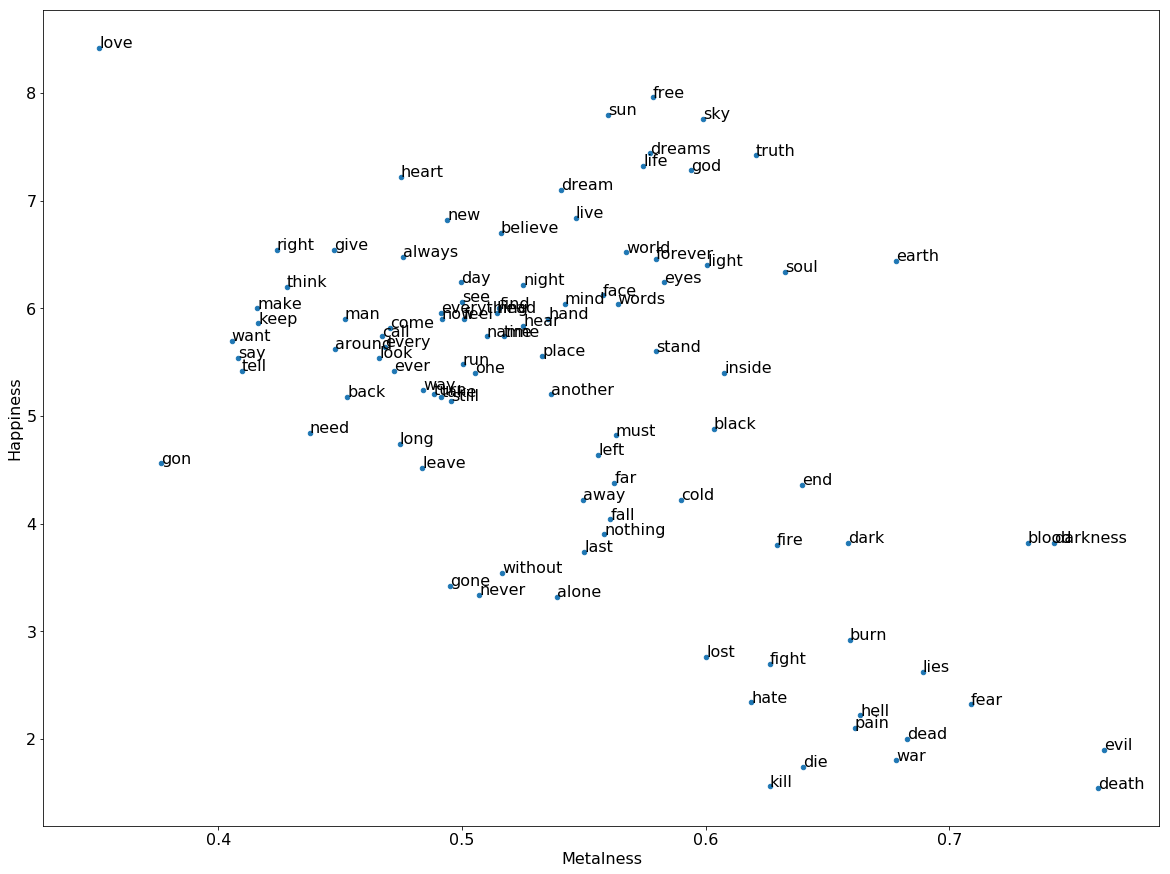

In [7]:
printmd("**Plot of the 100 most common words in the metal dataset**")
words_metalness_happs_100 = pd.merge(left=words_metalness_happs_df, right=freq_100_most_common_words_df, left_on='words', right_on='words') \
       .sort_values(['freq'], ascending=False).reset_index().drop(columns=['index'])
plot_scatter(
    words_metalness_happs_100,
    x="metalness",
    y="happs",
    xlabel="Metalness",
    ylabel="Happiness",
    figsize=(20, 15),
    labels="words",
    title="Happiness index against metalness index"
)

## Sentiment analysis with VADER
- Get the VADER sentiment index for eacxh song
- Calcuate the mean VADER sentiment index for each band
- Plot a reduct set of bands using metalness and VADER sentiment index as axes

In [8]:
def measure_lyrics_sentiment(text):
    text = text.replace('\\n\\n', '. ')
    text = text.replace('\\n', ' ')
    sentences = tokenize.sent_tokenize(text)
    scores = []
    sid = SentimentIntensityAnalyzer()
    compound = 0
    for sentence in sentences:
        scores.append(sid.polarity_scores(sentence))
    for score in scores:
        compound += score['compound']
        
    return compound / len(scores)

In [9]:
dataset_eng_full_df['sentiment_index'] = dataset_eng_full_df.lyrics.progress_apply(measure_lyrics_sentiment)

100%|██████████| 82413/82413 [10:14<00:00, 134.08it/s]


In [10]:
printmd("**Table of 5 most positive and most negative songs according to VADER index**")
dataset_eng_full_df = dataset_eng_full_df.sort_values(['sentiment_index'], ascending=False).reset_index().drop(columns=['index'])
dataset_eng_full_df

**Table of 5 most positive and most negative songs according to VADER index**

,artist,album,album_type,release_year,title,track_no,lyrics,swear_word_ratio,readability,metalness,sentiment_index
0,Riot,Restless Breed,Studio,1982,Loved By You,6,There I was talkin' 'bout you out on the stree...,0.000000,4,0.418369,0.9996
1,Lullacry,Vol. 4,Studio,2005,I Stole Your Love,11,I remember the day that we met\nI needed someo...,0.000000,7,0.399770,0.9993
2,Jorn,Unlocking The Past,Studio,2007,Feel Like Making Love,6,Whoa oh whoa oh\nBaby when I think about you I...,0.000000,6,0.377705,0.9993
3,Helloween,Unarmed,Studio,2009,Perfect Gentleman,7,There is no doubt about it I'm one of kind bab...,0.000000,7,0.446541,0.9993
4,Kix,Kix,Studio,1981,Love At First Sight,2,"Oh what an explosion, my hearts gonna fail\nIt...",0.004785,5,0.397046,0.9992
...,...,...,...,...,...,...,...,...,...,...,...
82408,Blood For Blood,Revenge On Society,Studio,1998,My Time Is Yet To Come,10,I sit alone in my dark room\nVisions of my lif...,0.041588,8,0.521173,-0.9997
82409,Blood For Blood,Spit My Last Breath,Studio,1999,Waiting For The Moment,8,Long lonely nights\nMy thoughts are a mess\nI ...,0.008850,7,0.540525,-0.9997
82410,Pegazus,Pegazus,Studio,1995,Pain Is My Friend,5,A broken heart\nIt's broke in two\n'Cause of a...,0.004673,4,0.569147,-0.9997
82411,Six Feet Under,Maximum Violence,Studio,1999,No Warning Shot,5,The end of all law\n4 shots fired another body...,0.061321,11,0.540205,-0.9997


In [11]:
temp_df = dataset_eng_full_df.groupby(['artist']).agg({
    'metalness': ['mean'],
    'readability': ['mean'],
    'sentiment_index': ['mean'],
    'swear_word_ratio': ['mean']
}, axis="columns").reset_index()
metalness_readability_sentiment_artists_df = pd.DataFrame({
    "artist": temp_df[('artist', '')],
    "sentiment": temp_df[('sentiment_index', 'mean')],
    "metalness": temp_df[('metalness', 'mean')],
    "readability": temp_df[('readability', 'mean')],
    "swear_word_ratio": temp_df[('swear_word_ratio', 'mean')],
}).sort_values(['sentiment'], ascending=False).reset_index().drop(columns=['index'])

printmd("**Table of 5 most positive and most negative bands according to VADER index**")
metalness_readability_sentiment_artists_df

**Table of 5 most positive and most negative bands according to VADER index**

,artist,sentiment,metalness,readability,swear_word_ratio
0,Stryper,0.200398,0.493130,4.636905,0.001608
1,Tnt,0.200137,0.480263,6.333333,0.001086
2,Arachnes,0.167354,0.514388,3.571429,0.000692
3,Neal Morse,0.160830,0.504103,5.817680,0.000589
4,Michael Sweet,0.152162,0.509391,6.154762,0.000403
...,...,...,...,...,...
995,Sadus,-0.642184,0.571663,7.865385,0.004539
996,Cenotaph,-0.662539,0.495691,12.208333,0.016765
997,Skeletonwitch,-0.676217,0.632308,7.370370,0.005197
998,Soilent Green,-0.702267,0.543257,11.037736,0.009273


#### Reduct set of bands to plot:

In [12]:
bands = [
    'Metallica',
    'Megadeth',
    'Slayer',
    'Annihilator',
    'Dream Theater',
    'Symphony X',
    'Ayreon',
    'Death',
    'Sepultura',
    'Motorhead',
    'Iron Maiden',
    'Judas Priest',
    'Dimmu Borgir',
    'Blind Guardian',
    'Children Of Bodom',
    'Satyricon',
    'Angra',
    'Manowar',
    'Helloween',
    'Gamma Ray',
    'Rage',
    'Mayhem',
    'Hammerfall',
    'Opeth',
    'Yngwie Malmsteen',
    'Pantera',
    'Black Sabbath',
    'Dio',
    'Anthrax',
    'Meshuggah',
    'Nightwish',
    'Rhapsody',
    'Stratovarius',
    'Therion',
    'Ozzy Osbourne',
    'W.A.S.P.',
    'Behemoth',
    'Vision Divine',
    'Running Wild',
    'Lacuna Coil',
    'Immortal',
    'Lamb Of God',
    'Overkill',
    'Sodom',
    'Kreator',
    'Kamelot',
    'Amon Amarth',
    'Savatage',
    'Venom',
    'Epica',
    'Morbid Angel',
    'Arch Enemy',
    'Cannibal Corpse',
    'Saxon',
    'Iced Earth',
    'Emperor',
    'Porcupine Tree',
    'Queensryche',
    'Darkthrone',
    'Virgin Steele',
    'Sonata Arctica',
    'Pain Of Salvation',
    'Destruction'
]

**Metalness/Happiness plan for a sample of 63 heavy metal bands**

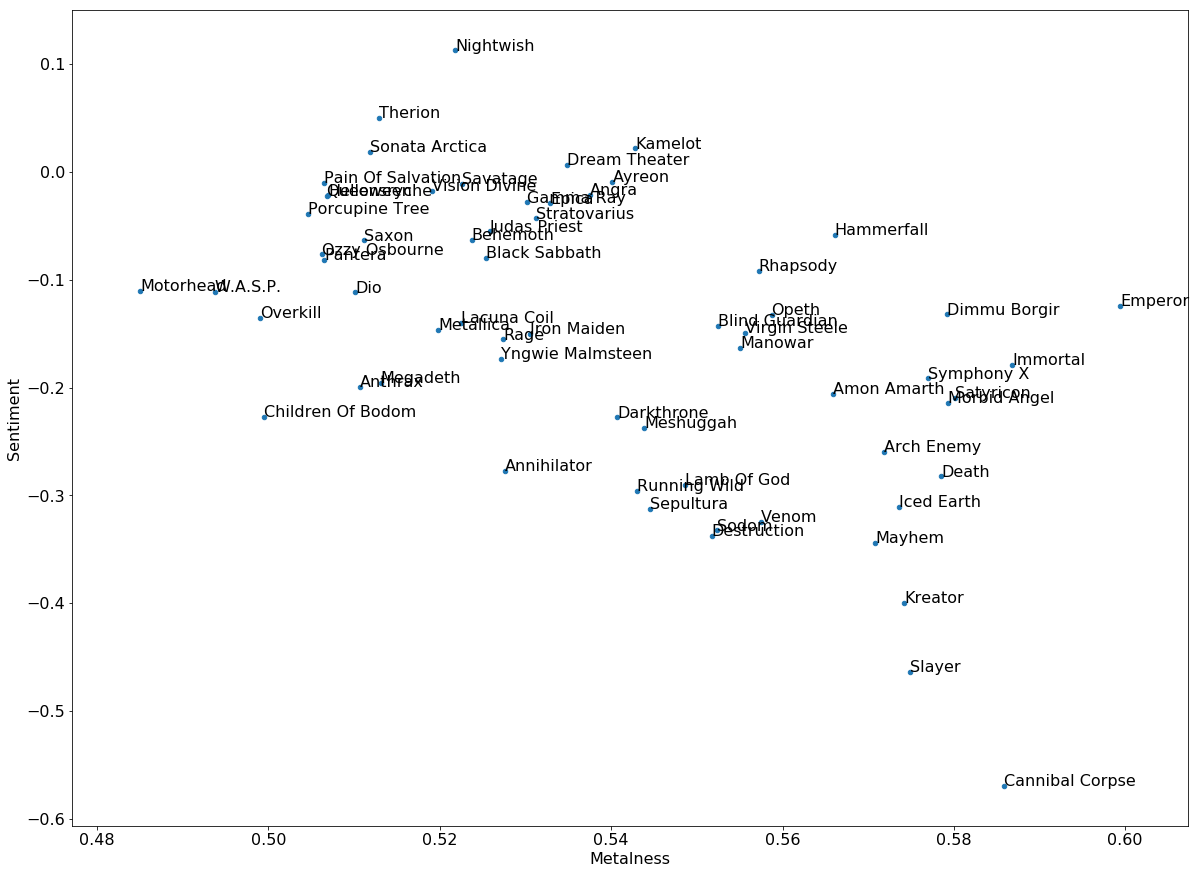

In [13]:
printmd("**Metalness/Happiness plan for a sample of 63 heavy metal bands**")
plot_scatter(
    metalness_readability_sentiment_artists_df[metalness_readability_sentiment_artists_df.artist.isin(bands)],
    x="metalness",
    y="sentiment",
    xlabel="Metalness",
    ylabel="Sentiment",
    figsize=(20, 15),
    labels="artist",
    title="Happiness index against metalness index"
)

## Bands emotional arcs
- Calculate mean VADER sentiment and metalness indexes per album;
- Select a reduct set of bands and plot the emotional arc (trend of metalness and sentiment through the albums). Bands chosen: Metallica, Dream Theater, Slayer;


In [14]:
temp_df = dataset_eng_full_df.groupby(['album']).agg({
    'artist': ['min'],
    'release_year': ['min'],
    'album_type': ['min'],
    'metalness': ['mean'],
    'readability': ['mean'],
    'sentiment_index': ['mean'],
    'swear_word_ratio': ['mean']
}, axis="columns").reset_index()
metalness_readability_sentiment_albums_df = pd.DataFrame({
    "album": temp_df[('album', '')],
    "album_type": temp_df[('album_type', 'min')],
    "artist": temp_df[('artist', 'min')],
    "release_year": temp_df[('release_year', 'min')],
    "sentiment": temp_df[('sentiment_index', 'mean')],
    "metalness": temp_df[('metalness', 'mean')],
    "readability": temp_df[('readability', 'mean')],
    "swear_word_ratio": temp_df[('swear_word_ratio', 'mean')],
}).sort_values(['sentiment'], ascending=False).reset_index().drop(columns=['index'])

printmd("**Table of 5 most positive and most negative albums according to VADER index**")
metalness_readability_sentiment_albums_df

**Table of 5 most positive and most negative albums according to VADER index**

,album,album_type,artist,release_year,sentiment,metalness,readability,swear_word_ratio
0,Suicide Is Beautiful,EP,Benighted In Sodom,2011,0.919400,0.539403,8.000000,0.000000
1,Breath From The Heaven,Studio,Tarja,2006,0.861920,0.496337,7.200000,0.000671
2,Fishing For Luckies,Studio,The Wildhearts,1994,0.812250,0.455593,5.000000,0.000000
3,Luka,EP,Kekal,2015,0.708075,0.552005,4.500000,0.000000
4,La Naissance D'Un Reve,Studio,Lacrimas Profundere,1997,0.645031,0.540562,7.000000,0.002193
...,...,...,...,...,...,...,...,...
8231,Funeral Dirge For The Rotting Sun,Studio,Goatwhore,2003,-0.987290,0.611938,11.700000,0.005883
8232,Stabwound Intercourse,Studio,Gorgasm,1998,-0.991367,0.560103,12.000000,0.055064
8233,Blood Of Tyrants,Studio,Exciter,2000,-0.991956,0.615647,9.777778,0.001107
8234,Kill Maim Burn,Studio,Debauchery,2003,-0.994150,0.615417,7.125000,0.006015


<img src="./common/resources/img/metallica.jpg">

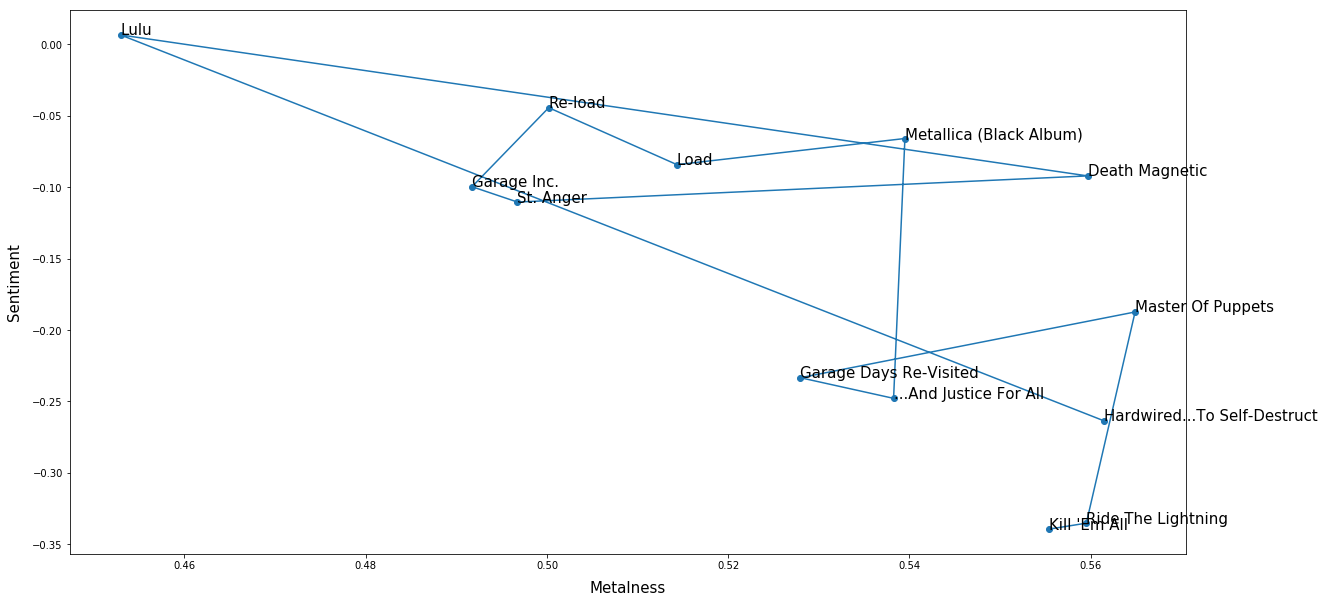

In [15]:
metallica_emotional_arc = metalness_readability_sentiment_albums_df[
    (metalness_readability_sentiment_albums_df.artist == 'Metallica') & 
    (metalness_readability_sentiment_albums_df.album_type == 'Studio')
].sort_values(['release_year'], ascending=True).reset_index().drop(columns=['index'])
plot_connected_scatter(
    data=[metallica_emotional_arc],
    x='metalness',
    xlabel='Metalness',
    y='sentiment',
    ylabel='Sentiment',
    figsize=(20, 10),
    annotation_field='album'
)

<img src="./common/resources/img/dt.jpg">

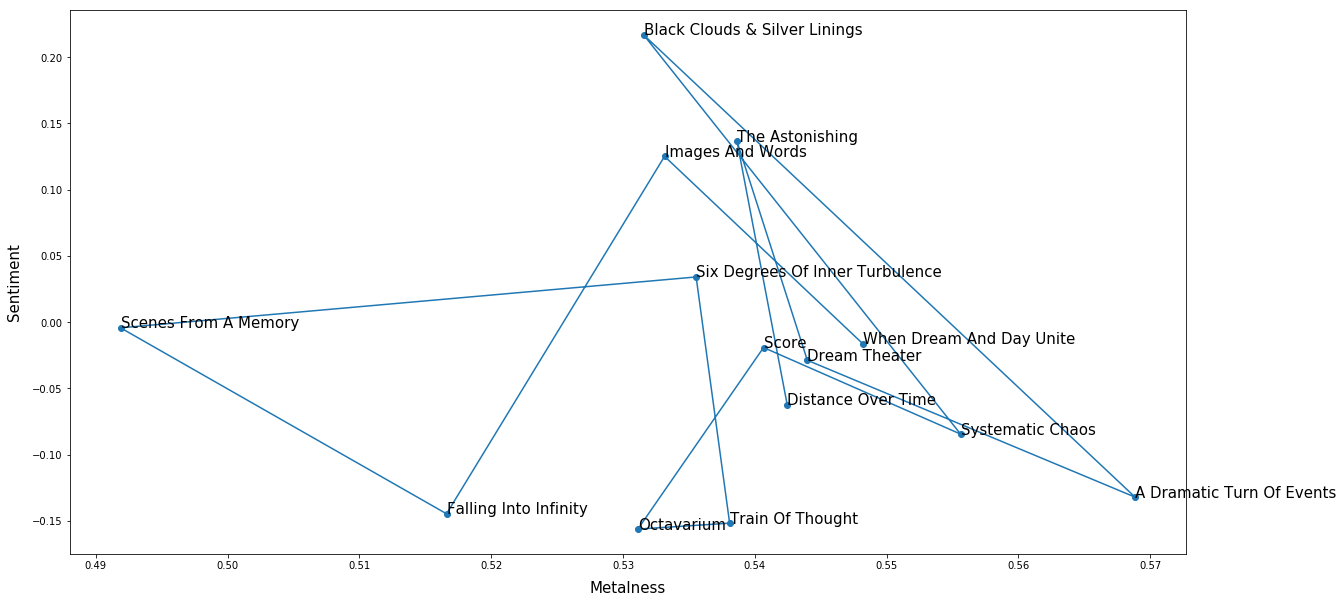

In [16]:
dt_emotional_arc = metalness_readability_sentiment_albums_df[
    (metalness_readability_sentiment_albums_df.artist == 'Dream Theater') & 
    (metalness_readability_sentiment_albums_df.album_type == 'Studio')
].sort_values(['release_year'], ascending=True).reset_index().drop(columns=['index'])
plot_connected_scatter(
    data=[dt_emotional_arc],
    x='metalness',
    xlabel='Metalness',
    y='sentiment',
    ylabel='Sentiment',
    figsize=(20, 10),
    annotation_field='album'
)

<img src="./common/resources/img/slayer.jpg">

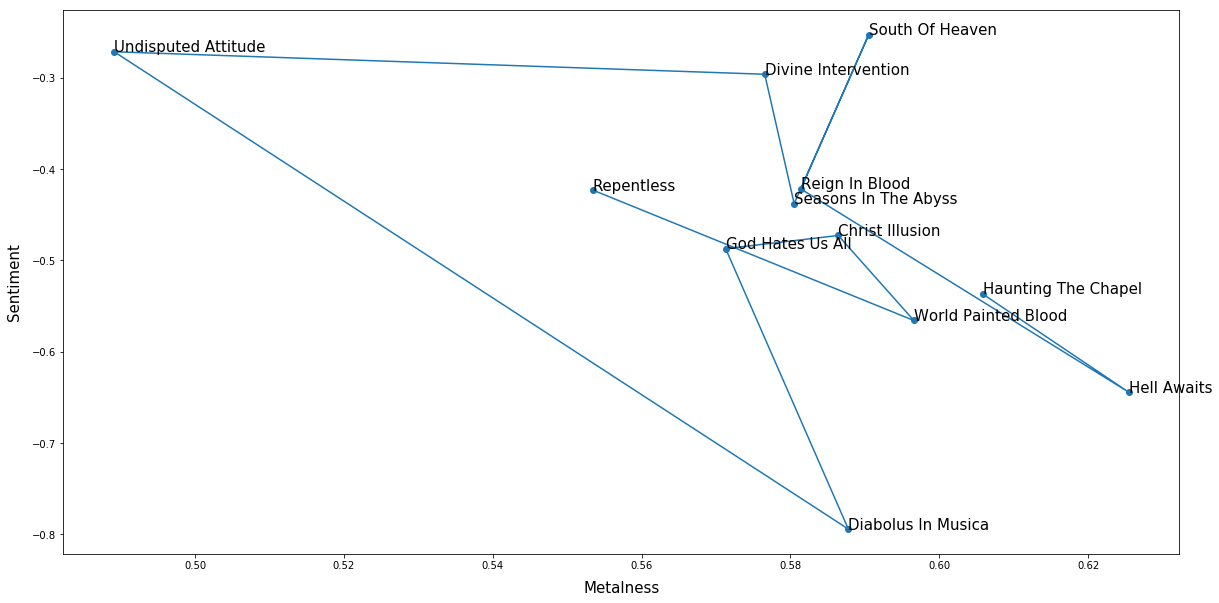

In [17]:
slayer_emotional_arc = metalness_readability_sentiment_albums_df[
    (metalness_readability_sentiment_albums_df.artist == 'Slayer') & 
    (metalness_readability_sentiment_albums_df.album_type == 'Studio')
].sort_values(['release_year'], ascending=True).reset_index().drop(columns=['index'])
plot_connected_scatter(
    data=[slayer_emotional_arc],
    x='metalness',
    xlabel='Metalness',
    y='sentiment',
    ylabel='Sentiment',
    figsize=(20, 10),
    annotation_field='album'
)

<img src="./common/resources/img/opeth.jpg">

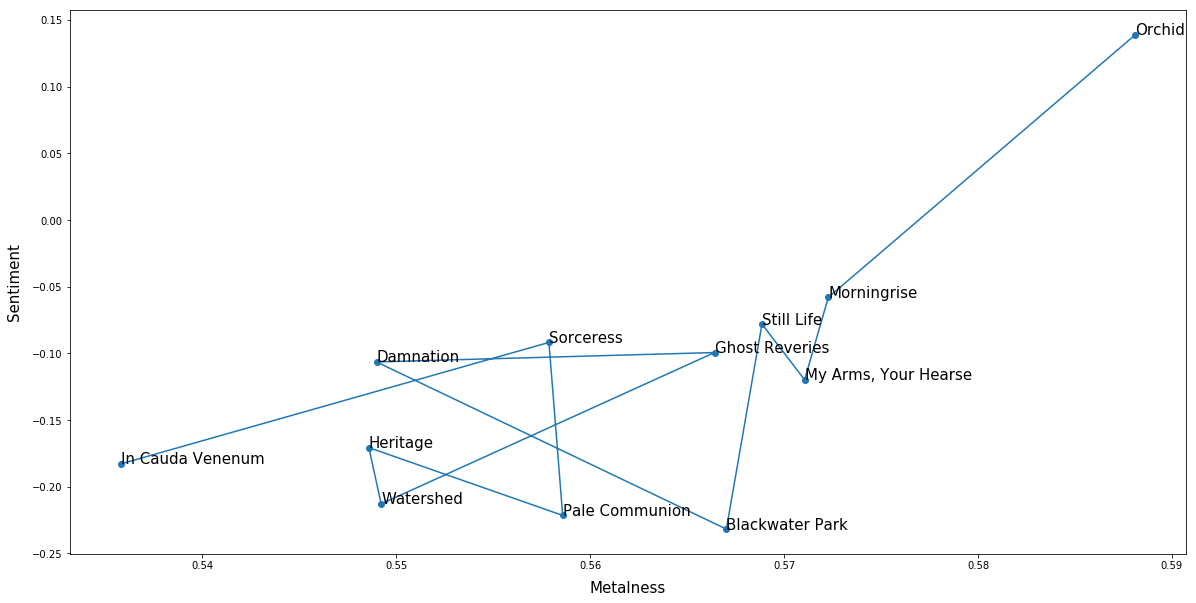

In [33]:
opeth_emotional_arc = metalness_readability_sentiment_albums_df[
    (metalness_readability_sentiment_albums_df.artist == 'Opeth') & 
    (metalness_readability_sentiment_albums_df.album_type == 'Studio')
].sort_values(['release_year'], ascending=True).reset_index().drop(columns=['index'])
plot_connected_scatter(
    data=[opeth_emotional_arc],
    x='metalness',
    xlabel='Metalness',
    y='sentiment',
    ylabel='Sentiment',
    figsize=(20, 10),
    annotation_field='album'
)

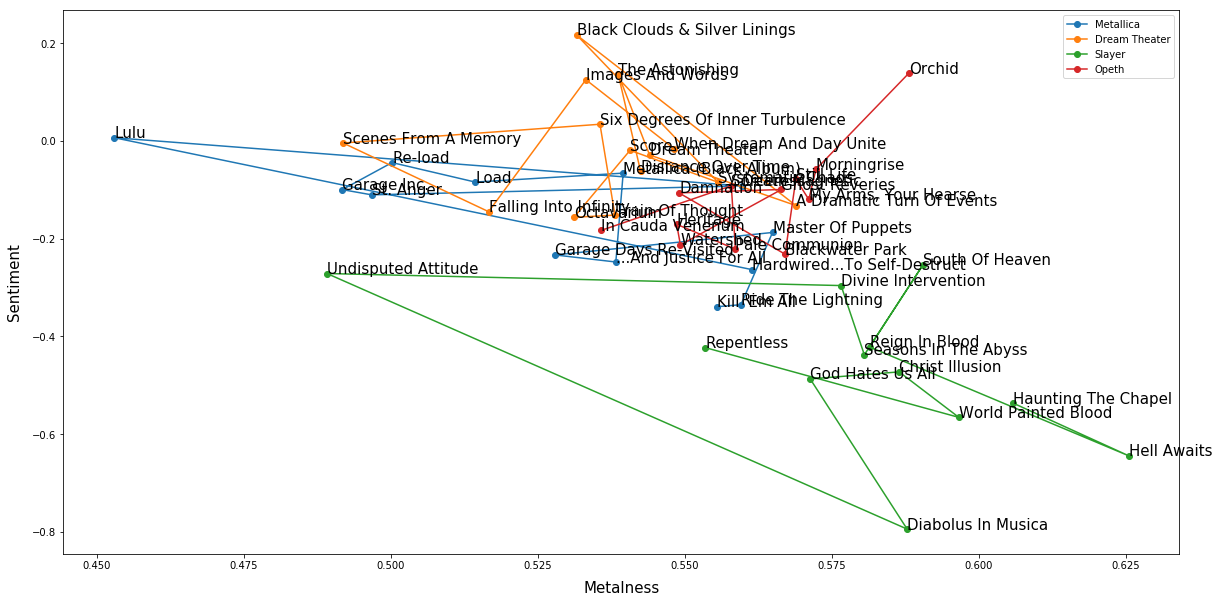

In [37]:
plot_connected_scatter(
    data=[metallica_emotional_arc, dt_emotional_arc, slayer_emotional_arc, opeth_emotional_arc],
    x='metalness',
    xlabel='Metalness',
    y='sentiment',
    ylabel='Sentiment',
    figsize=(20, 10),
    annotation_field='album',
    legend=['Metallica', 'Dream Theater', 'Slayer', 'Opeth']
)

## Emotional arcs applied to prose literature
- Calculate sentiment and metalness indexes for the books of the sagas:
    - The Lord of the Rings;
    - Harry Potter;
    - King James' Bible
- Plot a scatter with emotional arc per each saga;

## THE LORD OF THE RINGS

In [18]:
with open('../datasets/lotr/01_The_Fellowship_Of_The_Ring.txt', 'r', encoding='utf8') as file:
    lotr_fellowship_ring = file.read().replace('\n', '')
with open('../datasets/lotr/02_The_Two_Towers.txt', 'r', encoding='utf8') as file:
    lotr_two_towers = file.read().replace('\n', '')
with open('../datasets/lotr/03_The_Return_Of_The_King.txt', 'r', encoding='utf8') as file:
    lotr_return_king = file.read().replace('\n', '')

In [19]:
lotr_df = pd.DataFrame({
    'succession_order': [1, 2, 3],
    'book': ['The Fellowship Of The Ring', 'The Two Towers', 'The Return Of The King'],
    'text': [lotr_fellowship_ring, lotr_two_towers, lotr_return_king],
    'metalness': [0.443251, 0.445640, 0.449954]
})

In [20]:
lotr_df['sentiment'] = lotr_df.text.progress_apply(measure_lyrics_sentiment)

100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


In [21]:
lotr_df

,succession_order,book,text,metalness,sentiment
0,1,The Fellowship Of The Ring,﻿Three Rings for the Elven-kings under the sky...,0.443251,0.028642
1,2,The Two Towers,﻿ THE TWO TOWERS _b...,0.445640,0.011457
2,3,The Return Of The King,﻿ THE RETURN OF THE KING ...,0.449954,0.003694


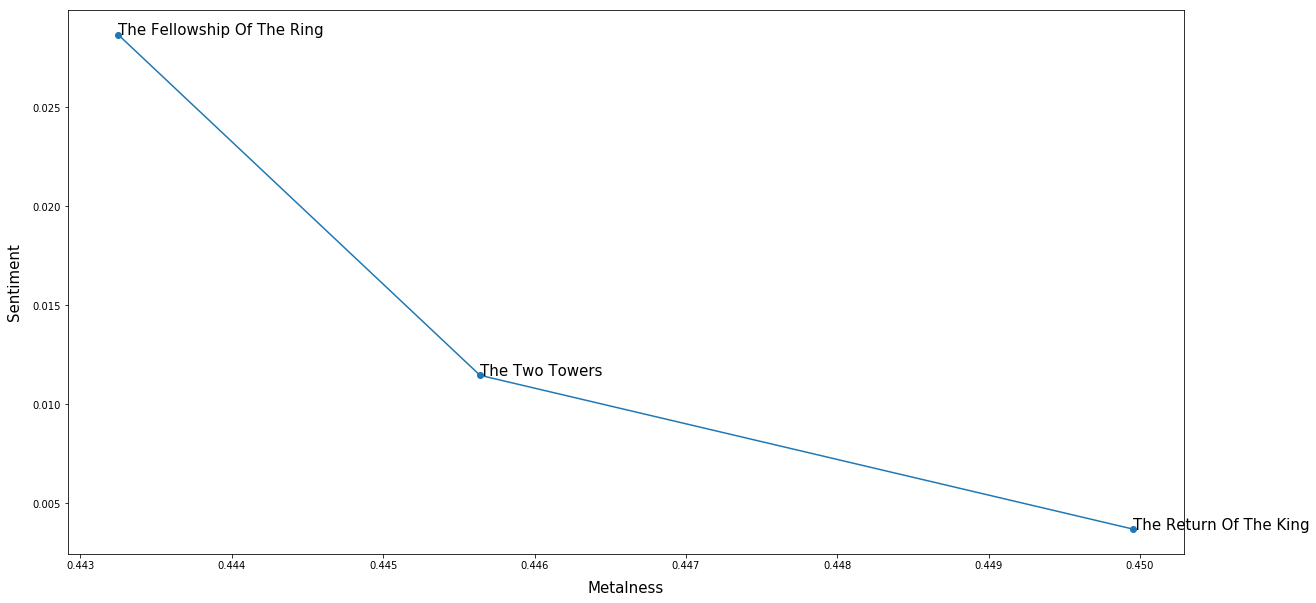

In [22]:
plot_connected_scatter(
    data=[lotr_df],
    x='metalness',
    xlabel='Metalness',
    y='sentiment',
    ylabel='Sentiment',
    figsize=(20, 10),
    annotation_field='book'
)

## HARRY POTTER

In [23]:
with open('../datasets/harrypotter/01_The_Philosophers_Stone.txt', 'r', encoding='utf8') as file:
    hp_the_philosophers_stone = file.read().replace('\n', '')
with open('../datasets/harrypotter/02_The_Chamber_of_Secrets.txt', 'r', encoding='utf8') as file:
    hp_the_chamber_of_secrets = file.read().replace('\n', '')
with open('../datasets/harrypotter/03_The_Prisoner_of_Azkaban.txt', 'r', encoding='utf8') as file:
    hp_the_prisoner_azkaban = file.read().replace('\n', '')
with open('../datasets/harrypotter/04_The_Goblet_of_Fire.txt', 'r', encoding='utf8') as file:
    hp_the_goblet_of_fire = file.read().replace('\n', '')
with open('../datasets/harrypotter/05_The_Order_of_the_Phoenix.txt', 'r', encoding='utf8') as file:
    hp_the_order_of_the_phoenix = file.read().replace('\n', '')
with open('../datasets/harrypotter/06_The_Half_Blood_Prince.txt', 'r', encoding='utf8') as file:
    hp_the_half_blood_prince = file.read().replace('\n', '')
with open('../datasets/harrypotter/07_The_Deathly_Hallows.txt', 'r', encoding='utf8') as file:
    hp_the_deathly_hallows = file.read().replace('\n', '')
    
harrypotter_df = pd.DataFrame({
    'succession_order': [1, 2, 3, 4, 5, 6, 7],
    'book': ["The Philosopher's Stone", "The Chamber of Secrets", "The Prisoner of Azkaban", "The Goblet of Fire", "The Order of the Phoenix", "The Half Blood Prince", "The Deathly Hallows"],
    'text': [hp_the_philosophers_stone, hp_the_chamber_of_secrets, hp_the_prisoner_azkaban, hp_the_goblet_of_fire, hp_the_order_of_the_phoenix, hp_the_half_blood_prince, hp_the_deathly_hallows],
    'metalness': [0.337457, 0.340450, 0.332510, 0.349361, 0.342585, 0.341983, 0.359345]
})
harrypotter_df['sentiment'] = harrypotter_df.text.progress_apply(measure_lyrics_sentiment)

100%|██████████| 7/7 [00:13<00:00,  1.92s/it]


In [24]:
harrypotter_df

,succession_order,book,text,metalness,sentiment
0,1,The Philosopher's Stone,"/ THE BOY WHO LIVED Mr. and Mrs. Dursley, of n...",0.337457,0.017078
1,2,The Chamber of Secrets,J . K . R O W L ! N G HARRY POTTER / THE WORST...,0.340450,0.001791
2,3,The Prisoner of Azkaban,/ OWL POST Harry Potter was a highly unusual b...,0.332510,-0.027775
3,4,The Goblet of Fire,/ THE RIDDLE HOUSE The villagers of Little Han...,0.349361,-0.008210
4,5,The Order of the Phoenix,HARRY POTTER I DUDLEY DEMENTED The hottest day...,0.342585,-0.003765
5,6,The Half Blood Prince,* J / THE OTHER MINISTER It was nearing midnig...,0.341983,0.020150
6,7,The Deathly Hallows,I * THE DARK LORD ASCENDING The two men appear...,0.359345,-0.028502


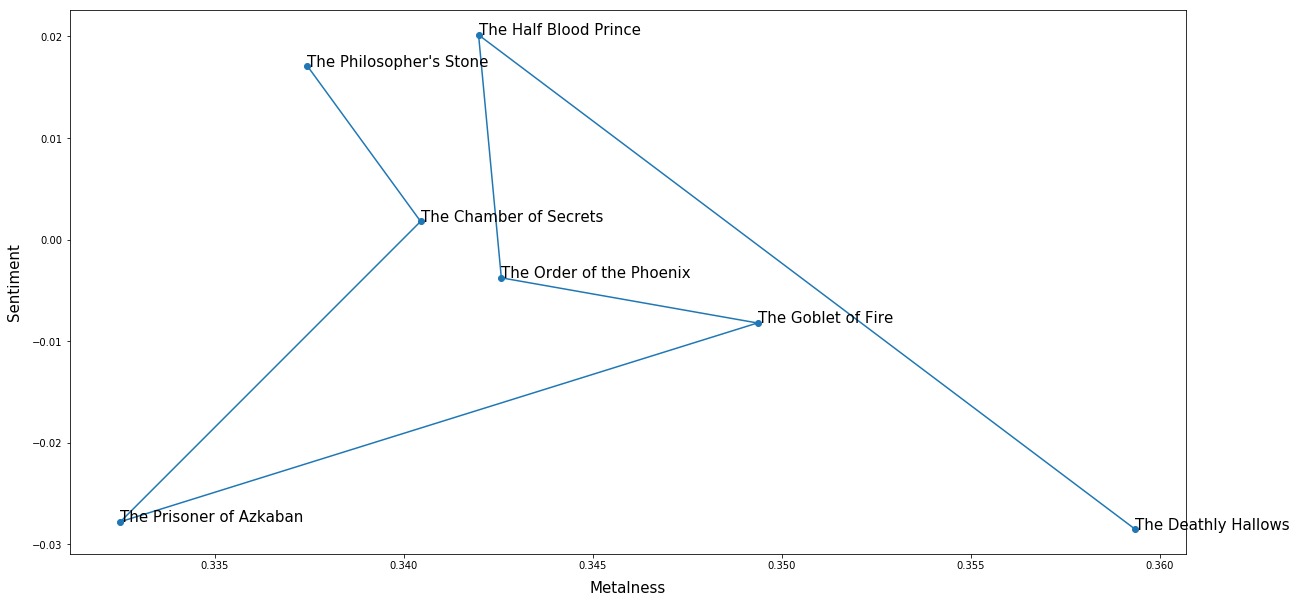

In [25]:
plot_connected_scatter(
    data=[harrypotter_df],
    x='metalness',
    xlabel='Metalness',
    y='sentiment',
    ylabel='Sentiment',
    figsize=(20, 10),
    annotation_field='book'
)

## THE HOLY BIBLE (King James version)

In [26]:
kj_bible_df = pd.read_csv('../datasets/kj_bible/kj_bible_splitted.csv', delimiter='|', encoding='utf-8')
kj_bible_df['sentiment'] = kj_bible_df.text.progress_apply(measure_lyrics_sentiment)
kj_bible_df['sentiment'] = kj_bible_df['sentiment'].astype(float)
kj_bible_df['metalness'] = kj_bible_df['metalness'].astype(float)

100%|██████████| 66/66 [00:08<00:00,  7.91it/s]


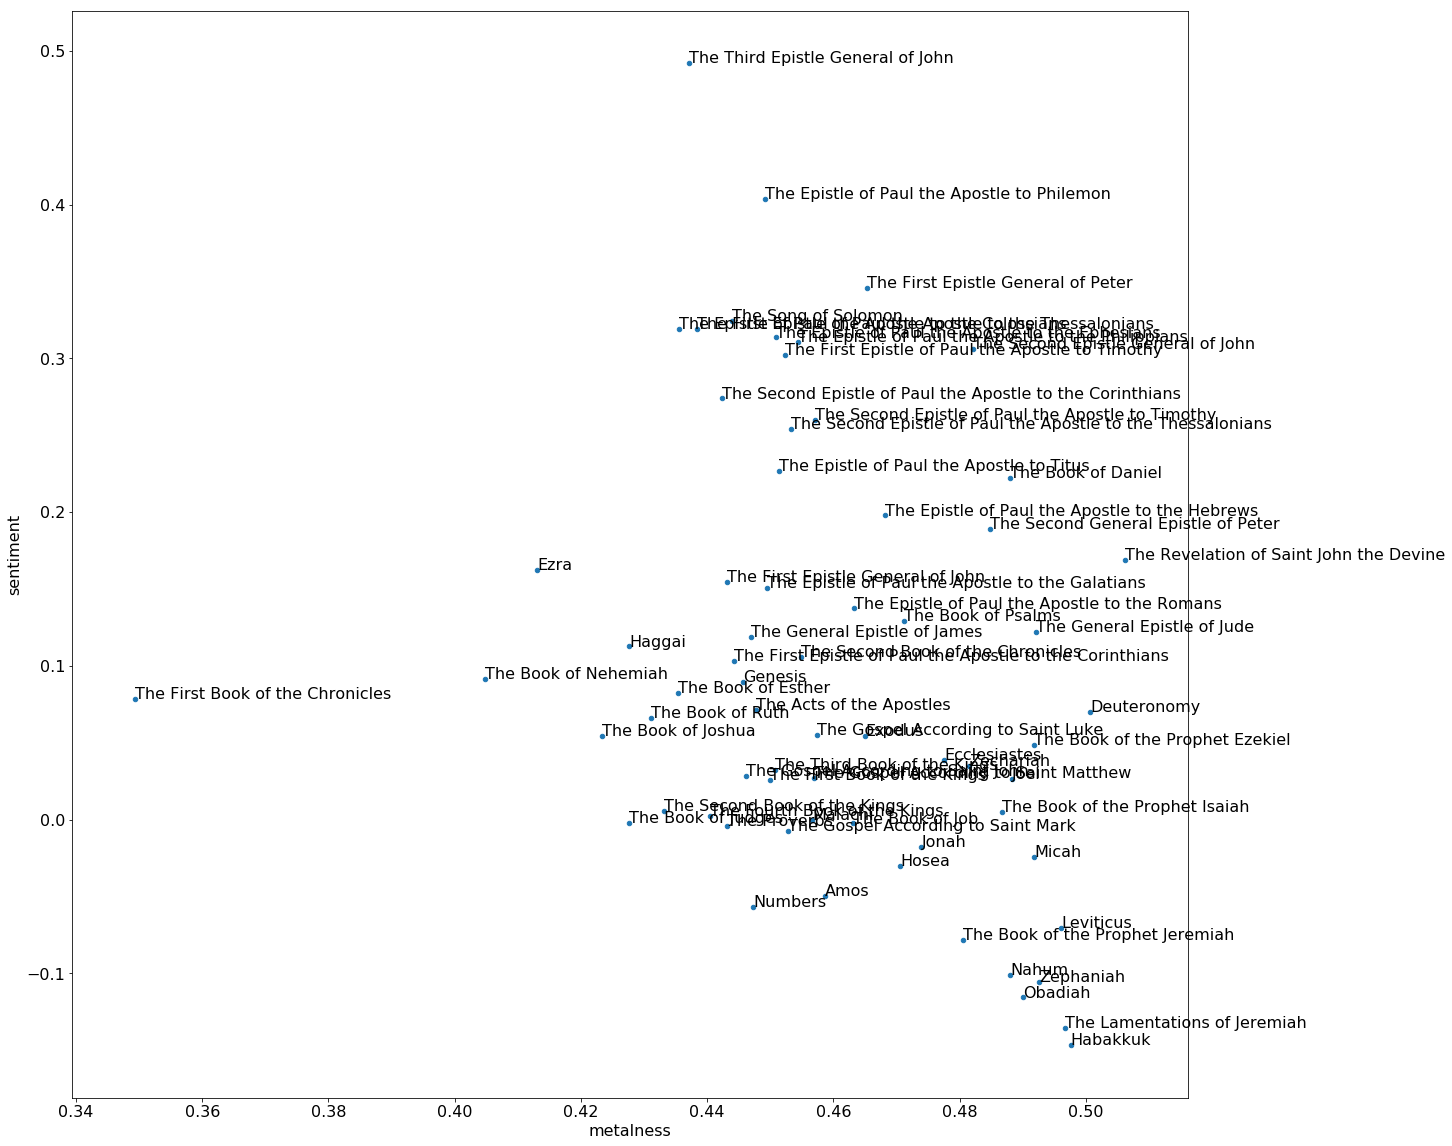

In [27]:
plot_scatter(
    kj_bible_df,
    x='metalness',
    xlabel='metalness',
    y='sentiment',
    ylabel='sentiment',
    figsize=(20, 20),
    labels='book',
    title=None,
    fontsize=16
)

## LDA Analysis

Perform a topic extraction task by using a Latent Dirichelet Allocation model: 
- Use all the documents in the english dataset;
- Remove punctuation and stopwords;
- Display the first 20 words per each topic (8)
- See if topics can be associated with a heavy metal sub-genre

In [28]:
# Preprocess the lyrics
def clean_lyrics_for_lda(text):
    text = text.lower().replace('\\n', ' ').replace('`', "'").replace('’', "'")
    text = text.replace("'ll", " will").replace("'ve", " have").replace("'cause", "because") \
        .replace("'bout", "about").replace("'re", " are").replace("don't", "do not").replace("can't", "can not") \
        .replace("talkin'", "talking").replace("ain't", "")
    text = re.sub(r'[^\w\s\']', ' ', text)
    text = text.replace(" oh ", " ").replace(" whoa", " ").replace(" yeah ", " ").replace(" ain ", " ") \
        .replace(" ah ", " ").replace(" na ", " ").replace(" thy ", " ").replace(" gon ", " ") \
        .replace(" hey ", " ").replace(" let ", " ").replace(" la ", " ").replace(" amp ", " ") \
        .replace(" uh ", " ").replace(" und ", " ").replace(" let ", " ").replace(" du ", " ") \
        .replace(" ich ", " ").replace(" der ", " ").replace(" et ", " ").replace(" im ", " ") \
        .replace(" den ", " ").replace(" em ", " ").replace(" est ", " ").replace(" es ", " ") \
        .replace(" oh ", " ").replace(" ooh ", " ")
            
    return text

lda_dataset_df = dataset_eng_full_df.copy()
lda_dataset_df['lyrics_lda'] = lda_dataset_df['lyrics']
lda_dataset_df['lyrics_lda'] = lda_dataset_df['lyrics_lda'].apply(clean_lyrics_for_lda)

In [29]:
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the lyrics
count_data = count_vectorizer.fit_transform(lda_dataset_df['lyrics_lda'])

In [42]:
# LDA model parameters
NUMBER_OF_TOPICS = 9
TOP_WORDS_PER_TOPIC = 20
TOP_DOCS_PER_TOPIC = 5
LDA_RANDOM_STATE = 38

# Print the topics found by the LDA model
def print_topics(model, count_vectorizer, docs_topic_distr=None):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic #{topic_idx}:")
        print(" ".join([words[i] for i in topic.argsort()[:-TOP_WORDS_PER_TOPIC - 1:-1]]))
        
        if(docs_topic_distr):
            top_doc_indices = np.argsort( docs_topic_distr[:,topic_idx] )[::-1][0:TOP_DOCS_PER_TOPIC]
            for doc_index in top_doc_indices:
                print(doc_index)
                display(lda_dataset_df.head(doc_index + 1).tail(1))
            
# Create and fit the LDA model
lda_model = LDA(n_components=NUMBER_OF_TOPICS, n_jobs=-1, random_state=LDA_RANDOM_STATE)
lda_model.fit(count_data)
docs_topic_distr = lda_model.transform(count_data)

print(f"\nTopics found via LDA:")
print_topics(lda_model, count_vectorizer)    


Topics found via LDA:

Topic #0:
dead blood death life pain flesh hate die fucking kill body lies face inside human skin head mind eyes self

Topic #1:
know just time away life way love feel say world day like make won want heart come need tell right

Topic #2:
death shall blood war world rise earth power fight gods come end black man fall hell souls die stand time

Topic #3:
war kill die man world time people law blood ready gun like death killing fight attack red streets end killer

Topic #4:
life time soul eyes night mind light world dark fear end pain inside come lost darkness death dreams feel free

Topic #5:
god hell holy lord evil devil satan son cross christ heaven father jesus blood come burn sin man black soul

Topic #6:
like love light heart eyes sun away night sky cold black rain burn tears come deep dark fall sea day

Topic #7:
got like just gonna know want wanna rock baby need fuck little make come right think love way feel man

Topic #8:
night ride sky metal land wind h